In [1]:
import matplotlib.pyplot as plt
import numpy as np
import similarity_measurement
import sklearn.svm as svm
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection

In [6]:
# For asap-dataset
# DATASET_ROOT = "../dataset/asap-dataset"
# SCORE_PREFIX = "midi_score"

# For newbie-dataset
DATASET_ROOT = "../dataset/newbie-dataset"
SCORE_PREFIX = "score"

NUM_SAMPLES = 100
QUEUE_SIZE = 8

SETTLING_FRAME = 3
FRAMES_PER_SECOND = 20  # Hz
SLICE_DURATION = [2.0, 5.0]  # sec
EXPANSION_RATE = [1.1, 3.0]
SUBSEQUENCE = True

In [7]:
pos_similarities, neg_similarities = similarity_measurement.run(dataset_root=DATASET_ROOT,
                                                                score_prefix=SCORE_PREFIX,
                                                                num_samples=NUM_SAMPLES,
                                                                queue_size=QUEUE_SIZE,
                                                                settling_frame=SETTLING_FRAME,
                                                                frames_per_second=FRAMES_PER_SECOND,
                                                                slice_duration=SLICE_DURATION,
                                                                expansion_rate=EXPANSION_RATE,
                                                                subsequence=SUBSEQUENCE,
                                                                shuffle=True, verbose=True)

[74] Histogram: 0.0513, Timewarping: 0.0349, Length ratio: 1.3614:  75%|███████▌  | 75/100 [00:19<00:06,  3.80it/s, ..\dataset\newbie-dataset\Clementi\sonatina_op36_no3_pt2\0_cjkim_1.mid, (slice_duration=3.28, expansion_rate=1.23)] 


In [8]:
pos_similarities = np.array(pos_similarities)
neg_similarities = np.array(neg_similarities)

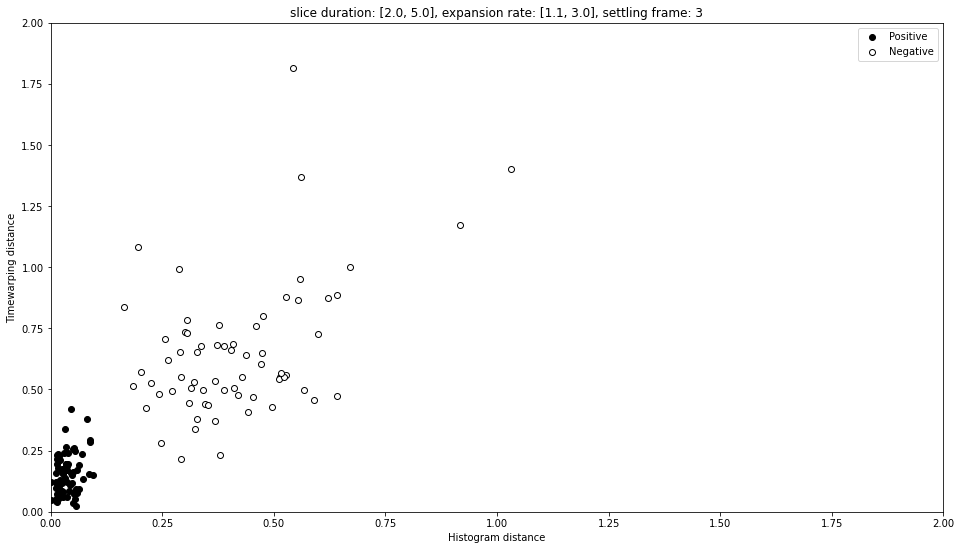

In [18]:
fig = plt.figure("scatter_2d", figsize=(16, 9), facecolor="white")
ax = fig.add_subplot()
ax.set_title(f"slice duration: {SLICE_DURATION}, expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.scatter(pos_similarities[:, 0], pos_similarities[:, 1], c="k", label="Positive")
ax.scatter(neg_similarities[:, 0], neg_similarities[:, 1], c="w", edgecolors="k", label="Negative")
ax.legend()
ax.set_xlim([0, 2])
ax.set_ylim([0, 2])
plt.show()

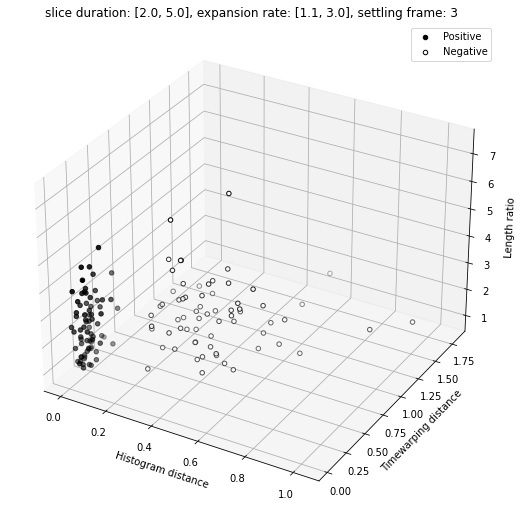

In [10]:
fig = plt.figure("scatter_3d", figsize=(16, 9), facecolor="white")
ax = fig.add_subplot(projection="3d")
ax.set_title(f"slice duration: {SLICE_DURATION}, expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.set_zlabel("Length ratio")
ax.scatter(pos_similarities[:,0], pos_similarities[:,1], pos_similarities[:,2], c="k", label="Positive")
ax.scatter(neg_similarities[:,0], neg_similarities[:,1], neg_similarities[:,2], c="w", edgecolors="k", label="Negative")
ax.legend()
plt.show()

In [11]:
x_total = np.concatenate([pos_similarities[:, :2], neg_similarities[:, :2]])
y_total = np.array([+1 for _ in range(len(pos_similarities))] + [-1 for _ in range(len(neg_similarities))])
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_total, y_total, test_size=0.2, stratify=y_total)
print(f"Train dataset: {x_train.shape=}, {y_train.shape}")
print(f"Test dataset: {x_test.shape=}, {y_test.shape}")

Train dataset: x_train.shape=(113, 2), (113,)
Test dataset: x_test.shape=(29, 2), (29,)


In [12]:
def score_dataset(clf, x, y_true):
    y_pred = clf.predict(x)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    return accuracy, f1_score

In [30]:
def plot_svm_contour(clf, x, y, h = 0.2):
    x0_min, x0_max = 0, int(np.ceil(x[:, 0].max()))
    x1_min, x1_max = 0, int(np.ceil(x[:, 1].max()))
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max+h, h), np.arange(x1_min, x1_max+h, h))
    z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
    zz = z.reshape(xx0.shape)
    plt.figure(figsize=(16, 9), facecolor="white")
    plt.contourf(xx0, xx1, zz, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.RdBu, s=20, edgecolors='k')
    plt.xlim([x0_min, x0_max])
    plt.ylim([x1_min, x1_max])
    plt.ylabel("Timewarping distance")
    plt.xlabel("Histogram distance")
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


Train score: accuracy=1.0000, f1_score=1.0000
Test score: accuracy=1.0000, f1_score=1.0000
Test score: accuracy=1.0000, f1_score=1.0000


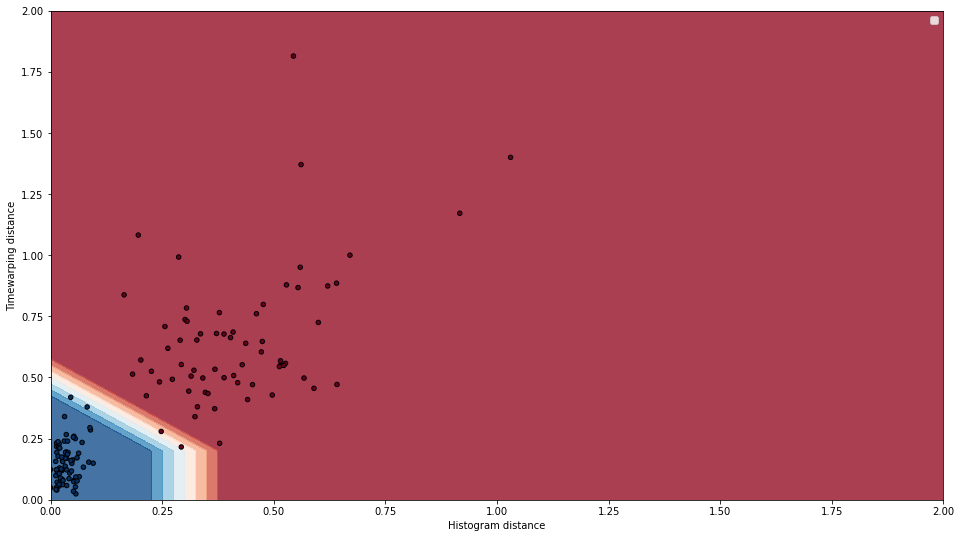

In [31]:
clf = svm.SVC(C=1)
clf.fit(x_train, y_train)

accuracy, f1_score = score_dataset(clf, x_train, y_train)
print(f"Train score: {accuracy=:.4f}, {f1_score=:.4f}")
accuracy, f1_score = score_dataset(clf, x_test, y_test)
print(f"Test score: {accuracy=:.4f}, {f1_score=:.4f}")
accuracy, f1_score = score_dataset(clf, x_total, y_total)
print(f"Test score: {accuracy=:.4f}, {f1_score=:.4f}")

plot_svm_contour(clf, x_total, y_total)